In [1]:
import os
import warnings
import matplotlib

import mne
import mne_bids
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report
from mne.preprocessing import annotate_movement

# Use matplotlib 

# BIDS Configuration
Setup ROOT, SUBJECT, SESSION and TASK and Load the RAW object.

In [27]:
# Configuration for BIDS data loading
BIDS_ROOT = '../data/BIDS'

# Define subject and session - modify these as needed
SUBJECT = 'P01'
SESSION = '01'
TASK = 'NaturalWalk'  # Options: TreadmillWalkComfortable, SittingEyesClosed, SittingEyesOpen, NaturalWalk

# Create BIDSPath with session information
bids_path = BIDSPath(
    root=BIDS_ROOT,
    subject=SUBJECT,
    session=SESSION,
    task=TASK,
    datatype='eeg'
)
raw = read_raw_bids(bids_path=bids_path, verbose=False)

print(f"Loading data for: {bids_path}")
print(f"Data info:\n{raw.info}")
print(f"RAW info: {raw}")

Loading data for: ../data/BIDS/sub-P01/ses-01/eeg/sub-P01_ses-01_task-NaturalWalk_eeg.vhdr
Data info:
<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: sub-P01, sex: 0, hand: 0>
>
RAW info: <RawBrainVision | sub-P01_ses-01_task-NaturalWalk_eeg.eeg, 64 x 80564 (322.3 s), ~80 KiB, data not loaded>


# Data Inspection and Initial Preprocessing

This section provides tools for manual data inspection and cleaning.

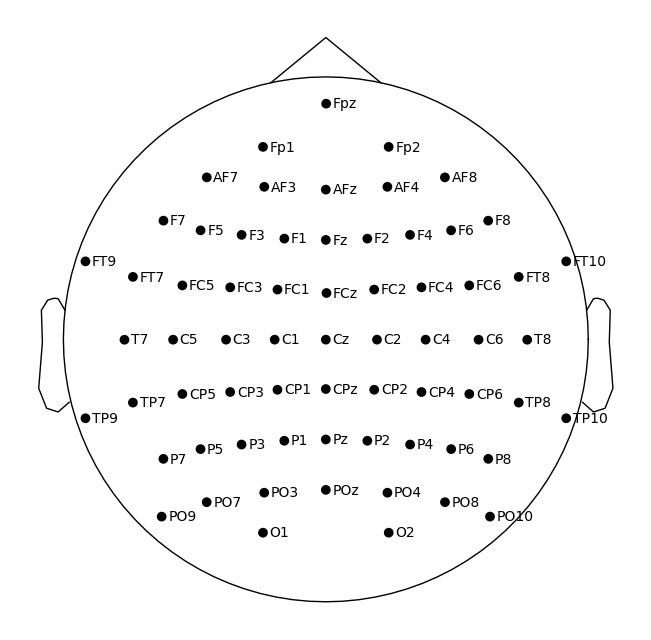

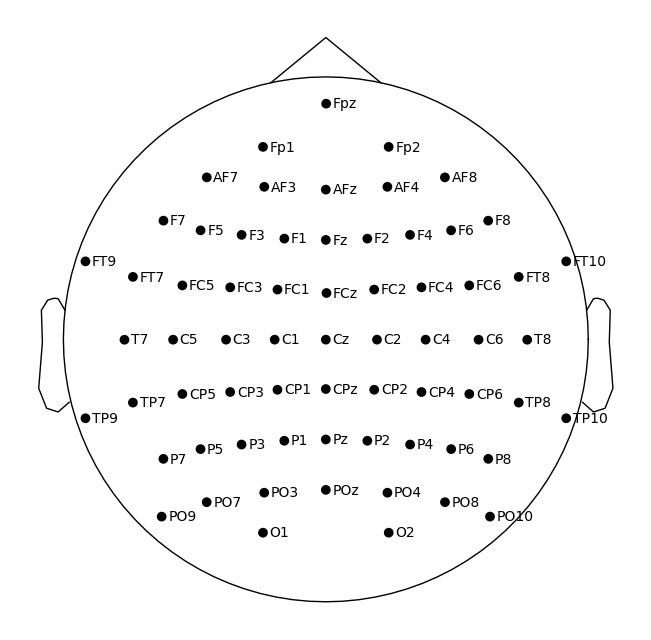

In [18]:
# Get the montage and print channel names and count them
montage = raw.get_montage()
ch_positions = montage.get_positions()['ch_pos']

standard_montage = mne.channels.make_standard_montage("standard_1020")
fpz_pos = standard_montage.get_positions()['ch_pos']['Fpz']
fcz_pos = standard_montage.get_positions()['ch_pos']['FCz']

ch_positions['Fpz'] = fpz_pos
ch_positions['FCz'] = fcz_pos

custom_montage = mne.channels.make_dig_montage(ch_positions, coord_frame='head')
raw.set_montage(custom_montage)

mne.viz.plot_montage(custom_montage, show_names=True, sphere='auto')

## Interactive Data Visualization

Use these cells to plot and inspect your data interactively.

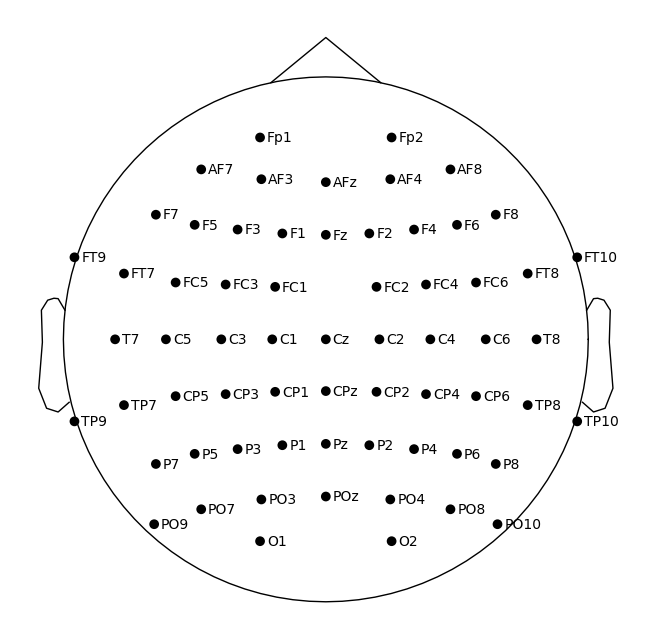

In [ ]:
# plot and exclude bad channels if any



Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\valtt\AppData\Local\Temp\ipykernel_4980\506855025.py:1: UserWarning: Zero value in spectrum for channel TP8
  fig = raw.compute_psd(tmax=np.inf, fmax=raw.info['sfreq'] / 2).plot(average=True, picks="data", exclude="bads")
C:\Users\valtt\AppData\Local\Temp\ipykernel_4980\506855025.py:1: UserWarning: Infinite value in PSD for channel TP8.
These channels might be dead.
  fig = raw.compute_psd(tmax=np.inf, fmax=raw.info['sfreq'] / 2).plot(average=True, picks="data", exclude="bads")
c:\Users\valtt\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


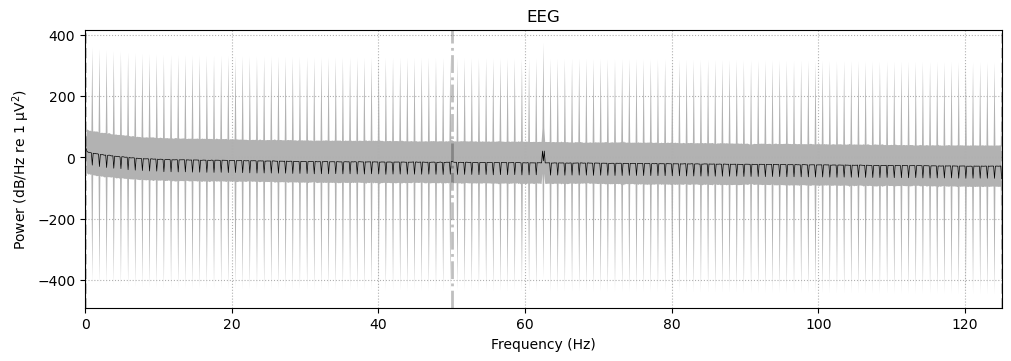

In [32]:
fig = raw.compute_psd(tmax=np.inf, fmax=raw.info['sfreq'] / 2).plot(average=True, picks="data", exclude="bads")

# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (50, 100, 150, 200):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(
            x=freqs[idx],
            y=psds[idx] + 18,
            dx=0,
            dy=-12,
            color="red",
            width=0.1,
            head_width=3,
            length_includes_head=True,
        )


In [ ]:
# Compute and plot the PSD
# fmax is set to a reasonable value to focus on relevant frequencies
spectrum = raw.compute_psd(fmax=100)
spectrum.plot(average=True, picks="eeg", exclude="bads")
spectrum.plot_topomap()

## Automatic Bad Channel Detection

Use these tools to automatically identify problematic channels.

In [ ]:
# Automatic bad channel detection
if 'raw' in locals():
    print("=== AUTOMATIC BAD CHANNEL DETECTION ===")
    
    # Store original bad channels
    original_bads = raw.info['bads'].copy()
    print(f"Originally marked bad channels: {original_bads}")
    
    # Method 1: Check for flat/dead channels
    flat_channels = []
    eeg_picks = mne.pick_types(raw.info, eeg=True)
    for pick in eeg_picks:
        ch_name = raw.ch_names[pick]
        data, _ = raw[pick, :]
        if np.std(data) < 1e-7:  # Very low standard deviation
            flat_channels.append(ch_name)
    
    print(f"Flat/dead channels detected: {flat_channels}")
    
    # Method 2: Check for channels with extreme amplitudes
    extreme_channels = []
    for pick in eeg_picks:
        ch_name = raw.ch_names[pick]
        data, _ = raw[pick, :]
        if np.max(np.abs(data)) > 500e-6:  # > 500 microvolts
            extreme_channels.append(ch_name)
    
    print(f"Channels with extreme amplitudes (>500µV): {extreme_channels}")
    
    # Method 3: Statistical outlier detection based on variance
    eeg_data = raw.get_data(picks='eeg')
    channel_vars = np.var(eeg_data, axis=1)
    var_threshold = np.percentile(channel_vars, 95)  # 95th percentile
    
    high_variance_channels = []
    for i, pick in enumerate(eeg_picks):
        ch_name = raw.ch_names[pick]
        if channel_vars[i] > var_threshold * 3:  # 3x the 95th percentile
            high_variance_channels.append(ch_name)
    
    print(f"High variance channels detected: {high_variance_channels}")
    
    # Combine all detected bad channels
    all_detected_bad = list(set(flat_channels + extreme_channels + high_variance_channels))
    print(f"\nALL DETECTED BAD CHANNELS: {all_detected_bad}")
    
    # Option to automatically mark them as bad
    if all_detected_bad:
        print(f"\nTo mark these as bad, run: raw.info['bads'] = {all_detected_bad}")
        print("Or add to existing bads:", list(set(original_bads + all_detected_bad)))
    else:
        print("\nNo problematic channels detected automatically.")

In [ ]:
# Manual bad channel marking (modify this list as needed)
if 'raw' in locals():
    
    # MODIFY THIS LIST based on your visual inspection and automatic detection
    manually_identified_bads = []  # e.g., ['Fp1', 'T7', 'P3']
    
    # Combine with any automatically detected bad channels
    if 'all_detected_bad' in locals():
        combined_bads = list(set(raw.info['bads'] + all_detected_bad + manually_identified_bads))
    else:
        combined_bads = list(set(raw.info['bads'] + manually_identified_bads))
    
    # Update bad channels
    raw.info['bads'] = combined_bads
    
    print(f"Updated bad channels: {raw.info['bads']}")
    print(f"Total bad channels: {len(raw.info['bads'])}")
    print(f"Remaining good EEG channels: {len(mne.pick_types(raw.info, eeg=True, exclude='bads'))}")

## Annotation Tools

Create annotations for artifacts, events, or time periods to exclude from analysis.

In [ ]:
# View existing annotations
if 'raw' in locals():
    print("=== EXISTING ANNOTATIONS ===")
    if len(raw.annotations) > 0:
        print(f"Number of annotations: {len(raw.annotations)}")
        print("Annotation details:")
        for i, (onset, duration, description) in enumerate(zip(raw.annotations.onset, 
                                                              raw.annotations.duration, 
                                                              raw.annotations.description)):
            print(f"  {i+1}. {onset:.2f}s - {onset+duration:.2f}s: {description}")
    else:
        print("No existing annotations found")
    
    # Display annotation statistics by type
    if len(raw.annotations) > 0:
        from collections import Counter
        ann_counts = Counter(raw.annotations.description)
        print(f"\nAnnotation types: {dict(ann_counts)}")

In [ ]:
# Manual annotation creation
# Use this cell to add custom annotations for artifacts or events

if 'raw' in locals():
    
    # Example: Add annotations manually
    # Modify the onset, duration, and description as needed
    
    # Template for adding annotations:
    new_annotations = [
        # Format: (onset_in_seconds, duration_in_seconds, 'description')
        # (120.0, 5.0, 'muscle_artifact'),
        # (200.0, 2.0, 'eye_blink_artifact'),
        # (300.0, 10.0, 'movement_artifact'),
    ]
    
    if new_annotations:
        from mne import Annotations
        
        # Extract components
        onsets = [ann[0] for ann in new_annotations]
        durations = [ann[1] for ann in new_annotations]
        descriptions = [ann[2] for ann in new_annotations]
        
        # Create new annotations
        new_ann = Annotations(onset=onsets, duration=durations, description=descriptions)
        
        # Add to existing annotations
        raw.set_annotations(raw.annotations + new_ann)
        
        print(f"Added {len(new_annotations)} new annotations")
        print("Updated total annotations:", len(raw.annotations))
    else:
        print("No new annotations to add (modify the new_annotations list above)")

In [ ]:
# Automatic movement artifact detection (useful for walking/movement tasks)
if 'raw' in locals() and 'walk' in TASK.lower():
    print("=== AUTOMATIC MOVEMENT ARTIFACT DETECTION ===")
    print("(Especially useful for walking tasks)")
    
    try:
        # Detect movement artifacts automatically
        # This is particularly useful for your walking tasks
        movement_annotations = annotate_movement(
            raw,
            pos=None,  # If you don't have head position data
            rotation_velocity_limit=None,  # Set if you have head position
            translation_velocity_limit=None,  # Set if you have head position
            use_magnetometer=False  # You're using EEG, not MEG
        )
        
        if len(movement_annotations) > 0:
            print(f"Detected {len(movement_annotations)} movement artifacts")
            # Add to existing annotations
            raw.set_annotations(raw.annotations + movement_annotations)
            print("Movement annotations added to data")
        else:
            print("No movement artifacts detected")
            
    except Exception as e:
        print(f"Movement detection failed: {e}")
        print("This is normal if you don't have magnetometer data")
        
        # Alternative: Simple amplitude-based artifact detection
        print("\nTrying amplitude-based artifact detection...")
        
        # Detect periods with high amplitude (possible movement artifacts)
        data = raw.get_data(picks='eeg')
        threshold = np.percentile(np.abs(data), 99)  # 99th percentile
        
        artifact_times = []
        window_size = int(raw.info['sfreq'] * 1.0)  # 1-second windows
        
        for i in range(0, data.shape[1] - window_size, window_size):
            window_data = data[:, i:i+window_size]
            if np.max(np.abs(window_data)) > threshold:
                start_time = i / raw.info['sfreq']
                artifact_times.append((start_time, 1.0, 'high_amplitude'))
        
        if artifact_times:
            print(f"Found {len(artifact_times)} high-amplitude periods")
            onsets = [t[0] for t in artifact_times]
            durations = [t[1] for t in artifact_times]
            descriptions = [t[2] for t in artifact_times]
            
            from mne import Annotations
            amplitude_ann = Annotations(onset=onsets, duration=durations, description=descriptions)
            raw.set_annotations(raw.annotations + amplitude_ann)
            print("High-amplitude annotations added")
        else:
            print("No high-amplitude artifacts detected")

## Data Filtering and Preprocessing

Apply filters and basic preprocessing steps.

In [ ]:
# Apply basic filtering
if 'raw' in locals():
    
    # Create a copy for filtering (preserve original)
    raw_filtered = raw.copy()
    
    print("=== APPLYING FILTERS ===")
    
    # 1. Notch filter for line noise (50 Hz or 60 Hz)
    # Modify this based on your country's power line frequency
    line_freq = 50  # Change to 60 for North America
    
    print(f"Applying notch filter at {line_freq} Hz...")
    raw_filtered.notch_filter(freqs=line_freq, picks='eeg')
    
    # 2. High-pass filter to remove slow drifts
    highpass_freq = 0.1  # Hz - modify as needed
    print(f"Applying high-pass filter at {highpass_freq} Hz...")
    raw_filtered.filter(l_freq=highpass_freq, h_freq=None, picks='eeg')
    
    # 3. Low-pass filter to remove high-frequency noise
    lowpass_freq = 100  # Hz - modify as needed
    print(f"Applying low-pass filter at {lowpass_freq} Hz...")
    raw_filtered.filter(l_freq=None, h_freq=lowpass_freq, picks='eeg')
    
    print("\\nFiltering complete!")
    print(f"Original sampling rate: {raw.info['sfreq']} Hz")
    print(f"Filtered data frequency range: {highpass_freq} - {lowpass_freq} Hz")
    
    # Option to downsample if needed
    target_sfreq = 250  # Hz - common choice for EEG
    if raw_filtered.info['sfreq'] > target_sfreq:
        print(f"\\nDownsampling from {raw_filtered.info['sfreq']} Hz to {target_sfreq} Hz...")
        raw_filtered.resample(target_sfreq)
        print("Downsampling complete!")

In [ ]:
# Compare raw vs filtered data
if 'raw' in locals() and 'raw_filtered' in locals():
    
    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Time domain comparison
    duration = 10  # seconds
    start_time = 60  # seconds
    picks = mne.pick_types(raw.info, eeg=True)[:5]  # First 5 EEG channels
    
    # Original data
    raw.plot(duration=duration, start=start_time, picks=picks, 
             scalings={'eeg': 100e-6}, show_scrollbars=False, show=False, ax=axes[0,0])
    axes[0,0].set_title('Original Data (Time Domain)')
    
    # Filtered data  
    raw_filtered.plot(duration=duration, start=start_time, picks=picks,
                     scalings={'eeg': 100e-6}, show_scrollbars=False, show=False, ax=axes[0,1])
    axes[0,1].set_title('Filtered Data (Time Domain)')
    
    # Frequency domain comparison
    # Original PSD
    raw.compute_psd(fmax=100).plot(picks='eeg', average=True, show=False, ax=axes[1,0])
    axes[1,0].set_title('Original Data (Frequency Domain)')
    
    # Filtered PSD
    raw_filtered.compute_psd(fmax=100).plot(picks='eeg', average=True, show=False, ax=axes[1,1])
    axes[1,1].set_title('Filtered Data (Frequency Domain)')
    
    plt.tight_layout()
    plt.show()
    
    print("Compare the plots to see the effect of filtering:")
    print("- Time domain: Should show smoother signals with less noise")
    print("- Frequency domain: Should show reduced line noise and high-frequency artifacts")

## Save Preprocessed Data

Save your cleaned and annotated data for further analysis.

In [ ]:
# Save preprocessed data
if 'raw_filtered' in locals():
    
    # Create output directory
    output_dir = Path('data/preprocessed')
    output_dir.mkdir(exist_ok=True)
    
    # Create filename
    output_filename = f"sub-{SUBJECT}_ses-{SESSION}_task-{TASK}_preprocessed.fif"
    output_path = output_dir / output_filename
    
    print(f"=== SAVING PREPROCESSED DATA ===")
    print(f"Output file: {output_path}")
    
    # Save the preprocessed data
    raw_filtered.save(output_path, overwrite=True)
    print("Preprocessed data saved!")
    
    # Create a summary report
    summary_filename = f"sub-{SUBJECT}_ses-{SESSION}_task-{TASK}_preprocessing_summary.txt"
    summary_path = output_dir / summary_filename
    
    with open(summary_path, 'w') as f:
        f.write(f"PREPROCESSING SUMMARY\\n")
        f.write(f"====================\\n\\n")
        f.write(f"Subject: {SUBJECT}\\n")
        f.write(f"Session: {SESSION}\\n") 
        f.write(f"Task: {TASK}\\n")
        f.write(f"Original sampling rate: {raw.info['sfreq']} Hz\\n")
        f.write(f"Final sampling rate: {raw_filtered.info['sfreq']} Hz\\n")
        f.write(f"Number of channels: {len(raw_filtered.ch_names)}\\n")
        f.write(f"Bad channels: {raw_filtered.info['bads']}\\n")
        f.write(f"Number of annotations: {len(raw_filtered.annotations)}\\n")
        f.write(f"Duration: {raw_filtered.times[-1]:.2f} seconds\\n\\n")
        
        if len(raw_filtered.annotations) > 0:
            f.write("ANNOTATIONS:\\n")
            for i, (onset, duration, description) in enumerate(zip(raw_filtered.annotations.onset, 
                                                                  raw_filtered.annotations.duration, 
                                                                  raw_filtered.annotations.description)):
                f.write(f"  {i+1}. {onset:.2f}s - {onset+duration:.2f}s: {description}\\n")
    
    print(f"Preprocessing summary saved to: {summary_path}")
    
    # Optionally create a BIDS derivative
    print("\\nTo save as BIDS derivative, you could use:")
    print("from mne_bids import write_raw_bids")
    print("# (This would require setting up proper derivative structure)")

## Quick Analysis Functions

Some helper functions for quick analysis and quality assessment.

In [ ]:
# Quick analysis and quality assessment functions

def quick_quality_check(raw_data, title="Data Quality Check"):
    """Quick quality assessment of EEG data"""
    
    print(f"=== {title.upper()} ===")
    
    # Basic statistics
    eeg_data = raw_data.get_data(picks='eeg')
    print(f"Shape: {eeg_data.shape} (channels x samples)")
    print(f"Duration: {raw_data.times[-1]:.2f} seconds")
    print(f"Sampling rate: {raw_data.info['sfreq']} Hz")
    print(f"Bad channels ({len(raw_data.info['bads'])}): {raw_data.info['bads']}")
    
    # Data quality metrics
    print(f"\\nDATA QUALITY METRICS:")
    print(f"  Mean amplitude: {np.mean(np.abs(eeg_data)):.2e} V")
    print(f"  Max amplitude: {np.max(np.abs(eeg_data)):.2e} V")
    print(f"  Min amplitude: {np.min(np.abs(eeg_data)):.2e} V")
    print(f"  Std deviation: {np.std(eeg_data):.2e} V")
    
    # Check for potential issues
    flat_channels = []
    noisy_channels = []
    threshold_flat = 1e-7
    threshold_noisy = np.percentile(np.std(eeg_data, axis=1), 95)
    
    for i, ch_name in enumerate(raw_data.ch_names):
        if raw_data.get_channel_types([ch_name])[0] == 'eeg':
            ch_std = np.std(eeg_data[i])
            if ch_std < threshold_flat:
                flat_channels.append(ch_name)
            elif ch_std > threshold_noisy:
                noisy_channels.append(ch_name)
    
    print(f"\\nPOTENTIAL ISSUES:")
    print(f"  Flat channels: {flat_channels if flat_channels else 'None detected'}")
    print(f"  Noisy channels: {noisy_channels if noisy_channels else 'None detected'}")
    print(f"  Annotations: {len(raw_data.annotations)} present")
    
    return {
        'flat_channels': flat_channels,
        'noisy_channels': noisy_channels,
        'mean_amplitude': np.mean(np.abs(eeg_data)),
        'max_amplitude': np.max(np.abs(eeg_data))
    }

def plot_channel_variance(raw_data, title="Channel Variance"):
    """Plot variance across channels to identify outliers"""
    
    eeg_data = raw_data.get_data(picks='eeg')
    eeg_picks = mne.pick_types(raw_data.info, eeg=True)
    ch_names = [raw_data.ch_names[i] for i in eeg_picks]
    
    variances = np.var(eeg_data, axis=1)
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(variances)), variances)
    plt.xlabel('Channel Index')
    plt.ylabel('Variance')
    plt.title(f'{title} - Channel Variance')
    plt.xticks(range(0, len(ch_names), max(1, len(ch_names)//10)), 
               [ch_names[i] for i in range(0, len(ch_names), max(1, len(ch_names)//10))], 
               rotation=45)
    
    # Mark bad channels
    bad_indices = [i for i, ch in enumerate(ch_names) if ch in raw_data.info['bads']]
    if bad_indices:
        plt.bar([i for i in bad_indices], [variances[i] for i in bad_indices], 
                color='red', alpha=0.7, label='Bad channels')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return variances

# Run quality check on current data
if 'raw' in locals():
    print("ORIGINAL DATA:")
    original_quality = quick_quality_check(raw, "Original Data")

if 'raw_filtered' in locals():
    print("\\n" + "="*50 + "\\n")
    print("FILTERED DATA:")
    filtered_quality = quick_quality_check(raw_filtered, "Filtered Data")

In [ ]:
# Plot channel variance comparison
if 'raw' in locals():
    print("Plotting channel variance for original data...")
    original_vars = plot_channel_variance(raw, "Original Data")

if 'raw_filtered' in locals():
    print("Plotting channel variance for filtered data...")
    filtered_vars = plot_channel_variance(raw_filtered, "Filtered Data")